In [1]:
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader
from IPython.display import clear_output

SEED = 1
BATCH_SIZE = 32
LR = 0.00030
EPOCHS = 4
CLIP = 0.1
GAMMA = 0.99
LAMBDA = 0.95
ENT_COEF = 0.01
V_CLIP = True

# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)


class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.pol = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )
        self.val = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 1)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.pol(out).reshape(out.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(out).reshape(out.shape[0], 1)

        return log_p, v


losses = []


def learn(net, old_net, optimizer, train_memory):
    global CLIP
    net.train()
    old_net.train()

    for i in range(EPOCHS):
        dataloader = DataLoader(
            train_memory,
            shuffle=True,
            batch_size=BATCH_SIZE,
            pin_memory=use_cuda
        )
        for (s, a, _s, ret, adv) in dataloader:
            s_batch = s.to(device).float()
            a_batch = a.to(device).long()
            _s_batch = _s.to(device).float()
            ret_batch = ret.to(device).float()
            adv_batch = adv.to(device).float()
            with torch.no_grad():
                log_p_batch_old, v_batch_old = old_net(s_batch)
                log_p_acting_old = log_p_batch_old[range(BATCH_SIZE), a_batch]

            log_p_batch, v_batch = net(s_batch)
            log_p_acting = log_p_batch[range(BATCH_SIZE), a_batch]
            p_ratio = (log_p_acting - log_p_acting_old).exp()
            p_ratio_clip = torch.clamp(p_ratio, 1. - CLIP, 1. + CLIP)
            p_loss = torch.min(p_ratio * adv_batch,
                               p_ratio_clip * adv_batch).mean()
            if V_CLIP:
                v_clip = v_batch_old + \
                    torch.clamp(v_batch - v_batch_old, -CLIP, CLIP)
                v_loss1 = (ret_batch - v_clip).pow(2)
                v_loss2 = (ret_batch - v_batch).pow(2)
                v_loss = torch.max(v_loss1, v_loss2).mean()
            else:
                v_loss = (ret_batch - v_batch).pow(2).mean()

            m = Categorical(log_p_batch.exp())
            entropy = m.entropy().mean()

            # loss
            loss = -(p_loss - 0.5 * v_loss + ENT_COEF * entropy)
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
            optimizer.step()
#         CLIP = max(CLIP * 0.999, 0.001)
    train_memory.clear()


def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()


def compute_adv_with_gae(rewards, values, roll_memory):
    rew = np.array(rewards, 'float')
    val = np.array(values[:-1], 'float')
    _val = np.array(values[1:], 'float')
    delta = rew + GAMMA * _val - val
    dis_r = np.array([GAMMA**(i) * r for i, r in enumerate(rewards)], 'float')
    gae_dt = np.array([(GAMMA * LAMBDA)**(i) * dt for i,
                       dt in enumerate(delta.tolist())], 'float')
    for i, data in enumerate(roll_memory):
        data.append(sum(dis_r[i:] / GAMMA**(i)))
        data.append(sum(gae_dt[i:] / (GAMMA * LAMBDA)**(i)))
    
    rewards.clear()
    values.clear()

    return roll_memory


def plot():
    clear_output(True)
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(ep_rewards)
    plt.title('Reward')
    plt.subplot(122)
    plt.plot(losses)
    plt.title('Loss')
    plt.show()

cuda: True


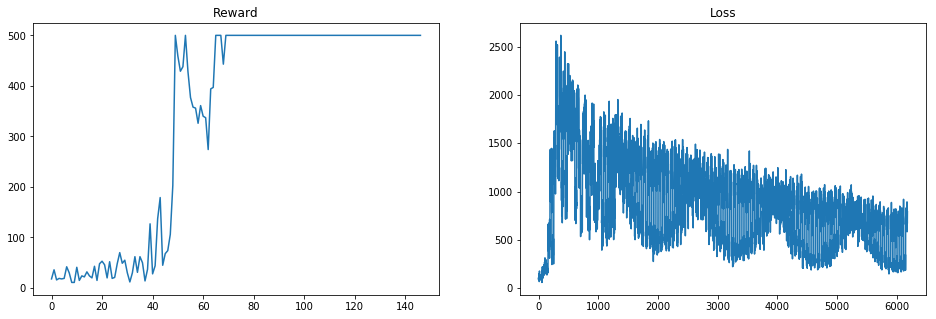


CartPole-v1 is sloved! 147 Episode in 49493 steps


In [2]:
# make an environment
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 2000
roll_len = 256
update_frq = 1
n_eval = env.spec.trials

# global values
steps = 0
learn_steps = 0
ep_rewards = []
reward_eval = deque(maxlen=n_eval)
is_rollout = False
is_solved = False

# make memories
net_memory = deque(maxlen=2)
train_memory = []
roll_memory = []
rewards = []
values = []

# make nerual networks
net = ActorCriticNet(obs_space, action_space).to(device)
old_net = deepcopy(net)

# make a optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=1e-5)

# play!
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        action, value = get_action_and_value(obs, old_net)
        _obs, reward, done, _ = env.step(action)

        # store
        roll_memory.append([obs, action, _obs])
        rewards.append(reward)
        values.append(value)

        obs = _obs
        steps += 1
        ep_reward += reward

        if done or steps % roll_len == 0:
            if done:
                _value = 0.
            else:
                _, _value = get_action_and_value(_obs, old_net)

            values.append(_value)
            train_memory.extend(compute_adv_with_gae(
                rewards, values, roll_memory))
            roll_memory.clear()

        if steps % (roll_len * update_frq) == 0:
            learn(net, old_net, optimizer, train_memory)
            old_net.load_state_dict(net.state_dict())

    if done:
        ep_rewards.append(ep_reward)
        plot()
#         print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
#             i, steps, ep_reward))

        if len(ep_rewards) >= n_eval:
            if np.mean(list(reversed(ep_rewards))[: n_eval]) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, steps))
                torch.save(net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_ppo_st.pt')
                break
env.close()

In [3]:
[
    ('CartPole-v0', 127, 32, 256),
    ('CartPole-v1', 147, 32, 256),
    ('MountainCar-v0', None),
    ('LunarLander-v2', None)
]

[('CartPole-v0', 127, 32, 128),
 ('CartPole-v1', 147, 32, 256),
 ('MountainCar-v0', None),
 ('LunarLander-v2', None)]